# Regression Study on Stock Prices 
Analyzing stock prices metrics and predicting stock prices from sentiment scores from stock prices. We used methods like :

-- XGBoost Regression 


In [228]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix


In [229]:
path_to_files = "stock_data/"
# path_to_sentiments1 = "stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_"
path_to_sentiments = "stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_"
path_to_global_news = "news_sentiment_scores/2000-2024/sentiment_analysis_results_"

stock_symbols = ['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']

interval = 14 # Time interval for Standard Moving Average calculation 
start_date = pd.to_datetime('2012-01-01').date()
end_date = pd.to_datetime('2023-01-01').date()



In [230]:
def categorize_change(x):
    if pd.isnull(x):
        return None  # For the first day
    elif x > 0:
        return 1
    else:
        return 0
    
def classify_price_difference(row):
    if row['PD'] > 0.5:  # Significant rise
        return 2
    elif row['PD'] < -0.5:  # Significant fall
        return 0
    else:
        return 1  # No significant change
    
def balanced_weighted_average(sentiment_scores, decay_factor):
    """
    Calculate a balanced weighted average of sentiment scores without biasing towards negative values.
    
    Parameters:
    - sentiment_scores: A list or pandas Series of sentiment scores (positive and negative).
    - decay_factor: A value between 0 and 1 to control the decay rate of weights; defaults to 0.95.
    
    Returns:
    - A single balanced weighted average score.
    """
    # Initialize positive and negative scores with respective weights
    positive_scores = sentiment_scores[sentiment_scores > 0]
    negative_scores = sentiment_scores[sentiment_scores < 0]
    
    # Calculate decay weights for each score in reverse order (older scores get smaller weights)
    decay_weights = decay_factor ** np.arange(len(sentiment_scores))[::-1]

    # Separate weights for positive and negative scores
    pos_weights = decay_weights[:len(positive_scores)]
    neg_weights = decay_weights[:len(negative_scores)]

    # Calculate the weighted average for positive and negative scores separately
    pos_weighted_avg = (positive_scores * pos_weights).sum() / pos_weights.sum() if len(pos_weights) > 0 else 0
    neg_weighted_avg = (negative_scores * neg_weights).sum() / neg_weights.sum() if len(neg_weights) > 0 else 0

    # Return the balanced average by combining positive and negative averages equally
    balanced_avg = (pos_weighted_avg + neg_weighted_avg) / 2

    return balanced_avg    



def preprocess_and_merge_data(stock_symbols, start_date, end_date, interval):
    merged_data = {}
    X_features_ = None

    for symbol in stock_symbols:
        ## Load data
        df_sentiment = pd.read_csv(path_to_sentiments + symbol + ".csv")
        df_stock = pd.read_csv(path_to_files + symbol + "/stock_price.csv")
        df_news = pd.read_csv(path_to_global_news + symbol + ".csv") 

        ## Convert date columns
        df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], utc=True).dt.date
        df_stock['Date'] = pd.to_datetime(df_stock['Date'], utc=True).dt.date
        df_news['Date'] = pd.to_datetime(df_news['Date'], utc=True).dt.date
        
        ## Rename columns
        rename_mapping1 = {
            'weighted positive sentiment score': 'Stock +ve Sentiment',
            'weighted negative sentiment score': 'Stock -ve Sentiment',
            'weighted neutral sentiment score': 'Stock Neutral',
            'weighted compound sentiment score': 'Stock Sentiment',
        }
        rename_mapping2 = {
            'weighted positive sentiment score': 'Global +ve Sentiment',
            'weighted negative sentiment score': 'Global -ve Sentiment',
            'weighted neutral sentiment score': 'Global Neutral',
            'weighted compound sentiment score': 'News Sentiment',
        }
        df_sentiment = df_sentiment.rename(columns=rename_mapping1)
        df_news = df_news.rename(columns=rename_mapping2)


        
        ## Filter by date range
        sentiment_filtered = df_sentiment[(df_sentiment['Date'] >= start_date) & (df_sentiment['Date'] <= end_date)]
        stock_filtered = df_stock[(df_stock['Date'] >= start_date) & (df_stock['Date'] <= end_date)]
        news_filtered = df_news[(df_news['Date'] >= start_date) & (df_news['Date'] <= end_date)]

        ## Remove 'Ticker' column
        sentiment_filtered = sentiment_filtered.drop(columns=['Ticker'])
        news_filtered = news_filtered.drop(columns=['Ticker'])
        
        ## Merge stock and sentiment data on common dates
        merged_df = pd.merge(stock_filtered, sentiment_filtered, on='Date', how='inner')

        ## Merge news data, filling missing values with zeros
        merged_df = pd.merge(merged_df, news_filtered, on='Date', how='left')
        news_columns = news_filtered.columns.tolist()
        # news_columns.remove('Date')
        merged_df[news_columns] = merged_df[news_columns].fillna(0)

        ## Compute Features and assgin target variables 
        merged_df.sort_values('Date', inplace=True)

        merged_df['SMA'] = merged_df['Close'].rolling(window= interval).mean()
        merged_df['Difference'] = merged_df['Close'].diff()
        # merged_df['Trend'] = merged_df['Close'].diff().apply(categorize_change)
        merged_df['PD'] = merged_df['Close'].pct_change() * 100

        # Drop the first row where PD is NaN
        merged_df = merged_df.dropna(subset=['PD'])

        # Apply classify_price_difference function
        merged_df['Price Movement'] = merged_df.apply(classify_price_difference, axis=1)

        X_features_ = merged_df.columns.tolist()
        merged_data[symbol] = merged_df.dropna()  # Drop NA after adding features
        
    return merged_data, X_features_


In [231]:
stock_data, Xfeatures = preprocess_and_merge_data(stock_symbols, start_date, end_date, interval)
stock_data['GOOG']

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock +ve Sentiment,Stock -ve Sentiment,Stock Neutral,Stock Sentiment,Global +ve Sentiment,Global -ve Sentiment,Global Neutral,News Sentiment,SMA,Difference,PD,Price Movement
13,2012-07-30,15.803062,15.965799,15.640322,15.709890,87795852,0.0,0.0,0.111000,0.000000,0.889000,0.653000,0.0,0.000000,0.000000,0.000000,15.316371,0.533685,3.516589,2
14,2012-08-13,16.085557,16.401843,16.067172,16.398365,131205956,0.0,0.0,0.031000,0.099395,0.909898,-0.582518,0.0,0.000000,0.000000,0.000000,15.383011,0.688475,4.382428,2
15,2012-09-11,17.341254,17.408089,17.168329,17.197895,75232938,0.0,0.0,0.111000,0.057000,0.832000,0.624900,0.0,0.000000,0.000000,0.000000,15.476395,0.799530,4.875669,2
16,2012-09-24,18.162153,18.635214,18.143520,18.618816,143086320,0.0,0.0,0.282000,0.000000,0.718000,0.962200,0.0,0.270101,0.778891,-0.376388,15.766361,1.420921,8.262182,2
17,2012-10-18,18.771866,18.868266,16.795644,17.267712,499561487,0.0,0.0,0.152560,0.118161,0.819924,0.164248,0.0,0.000000,0.000000,0.000000,15.989102,-1.351105,-7.256663,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,2022-12-22,88.712142,88.961529,86.727019,88.043785,23656100,0.0,0.0,0.278349,0.169534,0.889406,0.419258,0.0,0.000000,0.000000,0.000000,92.873348,-1.985115,-2.204975,0
882,2022-12-23,87.405351,89.879272,87.405351,89.589981,17815000,0.0,0.0,0.184420,0.000000,0.903706,0.255013,0.0,0.000000,0.000000,0.000000,92.156536,1.546196,1.756167,2
883,2022-12-27,89.091209,89.280746,87.320563,87.714592,15470900,0.0,0.0,0.212000,0.000000,0.788000,0.223500,0.0,0.000000,0.000000,0.000000,91.488178,-1.875389,-2.093302,0
884,2022-12-28,87.285645,88.303143,86.158416,86.248192,17879600,0.0,0.0,0.000000,0.174000,0.970219,-0.226300,0.0,0.000000,0.000000,0.000000,90.868985,-1.466400,-1.671786,0


In [232]:


print(Xfeatures)

Stock_Features = ['Volume', 'Open', 'Stock Sentiment', 'News Sentiment']
Stock_Metrics = ['SMA', 'Close', 'PD']
Trends = ['Price Movement']

print(type(stock_data['GOOG']))
print(stock_data['GOOG'].shape)



['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Stock +ve Sentiment', 'Stock -ve Sentiment', 'Stock Neutral', 'Stock Sentiment', 'Global +ve Sentiment', 'Global -ve Sentiment', 'Global Neutral', 'News Sentiment', 'SMA', 'Difference', 'PD', 'Price Movement']
<class 'pandas.core.frame.DataFrame'>
(873, 20)


In [233]:
stock_data['GOOG'][Features]

,High,Stock Sentiment,News Sentiment
13,15.965799,0.653000,0.000000
14,16.401843,-0.582518,0.000000
15,17.408089,0.624900,0.000000
16,18.635214,0.962200,-0.376388
17,18.868266,0.164248,0.000000
...,...,...,...
881,88.961529,0.419258,0.000000
882,89.879272,0.255013,0.000000
883,89.280746,0.223500,0.000000
884,88.303143,-0.226300,0.000000


In [234]:
# g = sns.pairplot(stock_data['GOOG'], x_vars=Features, y_vars=Targets)
# names = df.columns.map(lambda t: t.split('(')[0])
# for i in range(8):
#     g.axes[0,i].xaxis.set_label_text(names[i])
#     g.axes[0,i].yaxis.set_label_text(names[8])
# plt.show()
# # plt.show()

In [235]:
# plt.scatter(stock_data['GOOG']['weighted compound sentiment score'], stock_data['GOOG']['Price Difference'])

In [236]:
def train_predict(data, features, target, param_grid):
    results = {}

    for ticker, df in data.items():
        # Train-test split
        split_index = int(len(df) * 0.9)
        train_data = df.iloc[:split_index]
        test_data = df.iloc[split_index:]
        # Separate features (X) and target (y)
        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]
        # print(X_train.sample(10))
        # print(X_test.sample(10))
        
        xgb_reg = XGBRegressor()
        tscv = TimeSeriesSplit(n_splits=5)
        search = GridSearchCV(xgb_reg, param_grid, cv=tscv).fit(X_train, y_train)
        print("The best hyperparameters are ",search.best_params_)
        # Train XGBoost Model
        xgb_reg = XGBRegressor(**search.best_params_)
        xgb_reg.fit(X_train, y_train)

        # Predictions
        y_pred = xgb_reg.predict(X_test)

        # Evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred) 
        print(f"{ticker} - MSE: {mse:.4f}, MAE: {mae:.4f}")

        # Store Results
        results[ticker] = {
            'model': xgb_reg,
            'mse': mse,
            'mae': mae,
            'y_test': y_test,
            'y_pred': y_pred
        }

    return results

def plot_predictions(results, target):
    for ticker, result in results.items():
        plt.figure(figsize=(10, 5))
        plt.plot(result['y_test'].values, label='Actual', marker='o', color = "RoyalBlue")
        plt.plot(result['y_pred'], label='Predicted', marker='x' , color = "Red")
        plt.title(f'{ticker} - Predicted vs Actual ({target})')
        plt.legend()
        plt.show()



In [237]:
results = []

param_grid = {"max_depth":    [4, 6, 8, 10],
              "n_estimators": [200, 400, 500, 800, 1000, 1200],
              "learning_rate": [0.01, 0.1, 1]}



for target in Stock_Metrics:
    print(target)
    res = train_predict(stock_data, Features, target, param_grid)
    
    results.append(res)

SMA
The best hyperparameters are  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 1200}
GOOG - MSE: 56.3032, MAE: 6.4027
The best hyperparameters are  {'learning_rate': 1, 'max_depth': 4, 'n_estimators': 200}
MSFT - MSE: 213.1661, MAE: 12.1567
The best hyperparameters are  {'learning_rate': 1, 'max_depth': 4, 'n_estimators': 200}
NVDA - MSE: 2.2252, MAE: 1.1919
The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 800}
AMZN - MSE: 73.4496, MAE: 6.5685
The best hyperparameters are  {'learning_rate': 1, 'max_depth': 4, 'n_estimators': 200}
AAPL - MSE: 54.7944, MAE: 6.1723
Close
The best hyperparameters are  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
GOOG - MSE: 6.2468, MAE: 1.9269
The best hyperparameters are  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1200}
MSFT - MSE: 11.3658, MAE: 2.6076
The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1200}
NVDA - MSE: 0.1268, MAE: 0.2593
The be

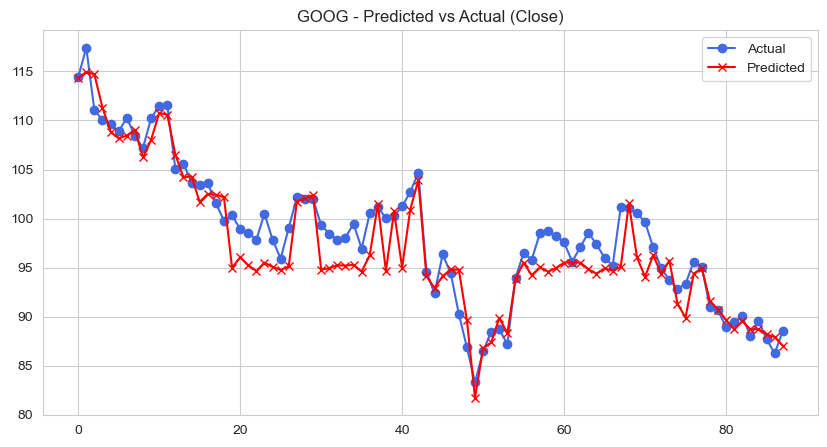

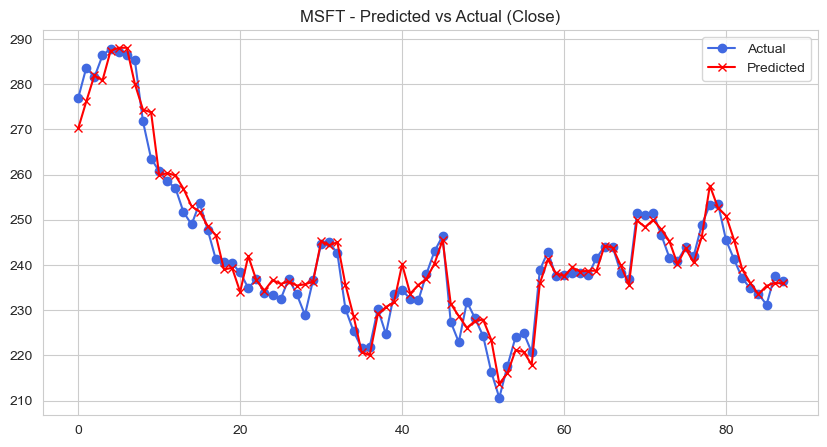

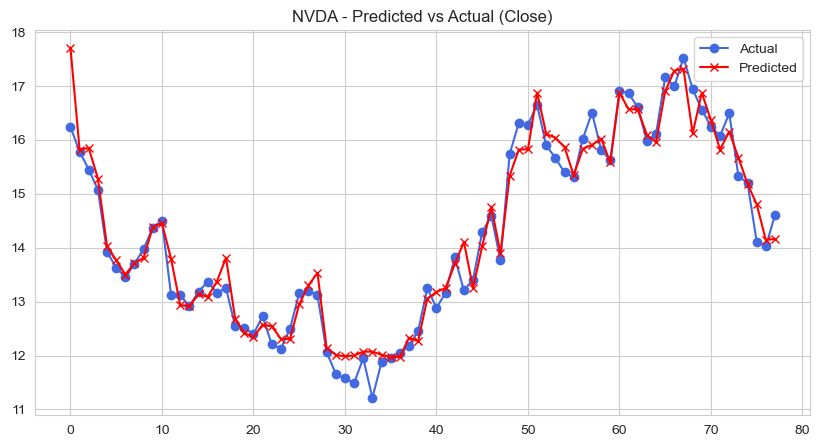

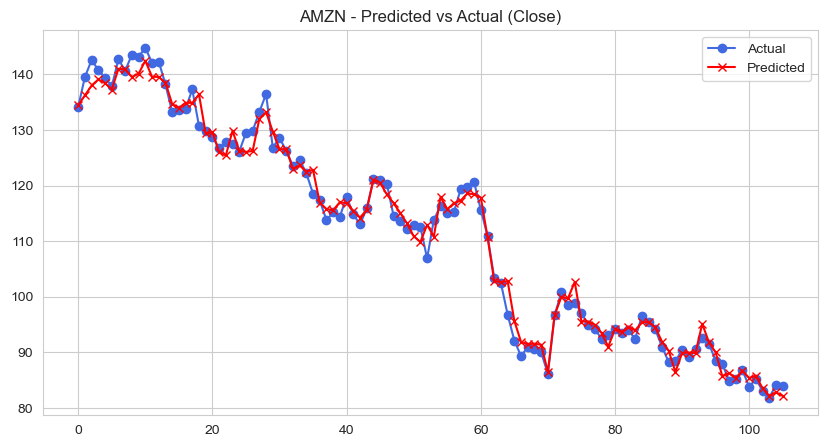

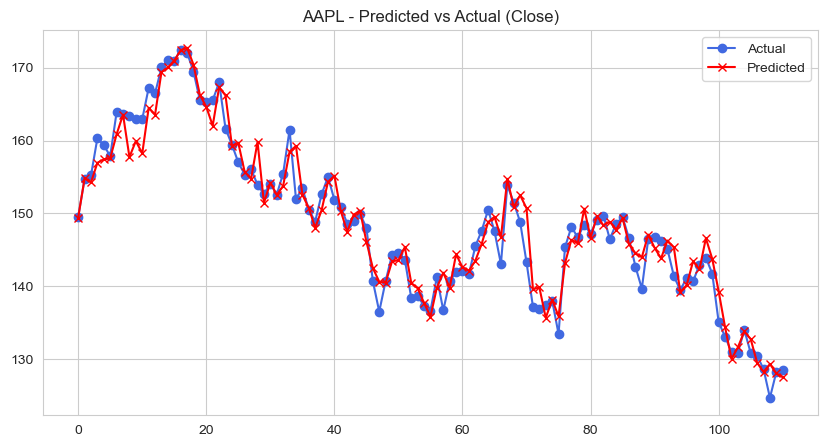

In [254]:
k = 1
plot_predictions(results[k], Stock_Metrics[k])

In [239]:
# def train_predict_trend(data, features, target):
#     results = {}

#     for ticker, df in data.items():
#         # Prepare data
#         X = df[features]
#         y = df[target]

#         # Train-test split
#         split_index = int(len(df) * 0.9)
#         train_data = df.iloc[:split_index]
#         test_data = df.iloc[split_index:]

#         # Separate features (X) and target (y)
#         X_train = train_data[features]
#         y_train = train_data[target]
#         X_test = test_data[features]
#         y_test = test_data[target]

#         model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
#         model.fit(X_train, y_train)

#         # Predictions
#         y_pred = model.predict(X_test)

#         # Evaluate
#         print(f"Classification Report for {ticker}:")
#         print(classification_report(y_test, y_pred))
        
#         cm = confusion_matrix(y_test, y_pred)
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#         plt.title(f'{ticker} - Confusion Matrix')
#         plt.xlabel('Predicted')
#         plt.ylabel('Actual')
#         plt.show()

#         # Store results
#         results[ticker] = {
#             'model': model,
#             'y_test': y_test,
#             'y_pred': y_pred
#         }

#     return results



In [240]:

# classification_results = train_predict_trend(stock_data, Features, target= 'Price Movement')


In [241]:
# mses = {}
# for name, model in models.items():
#     model.fit(stock_data['GOOG'][Features],stock_data['GOOG'][Stock_Metrics[0]])
#     mses[name] = mean_squared_error(stock_data['GOOG'][Stock_Metrics[0]], model.predict(stock_data['GOOG'][Features]))

In [242]:
# mses

In [249]:
def train_models(data, features, target, models):
    results = {}

    for ticker, df in data.items():
        # Train-test split
        split_index = int(len(df) * 0.95)
        # print(split_index, int(len(df)))
        train_data = df.iloc[:split_index]
        test_data = df.iloc[split_index:]
        # Separate features (X) and target (y)
        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]
        
        # Initialize a results dictionary for this ticker
        results[ticker] = {}

        for name, model in models.items():
            model.fit(X_train,y_train)
        
            # Predictions
            y_pred = model.predict(X_test)

            # Evaluation
            mse = mean_squared_error(y_test, y_pred) 
            print(f"{ticker} - Metrics : {target} - Model: {name} - MSE: {mse:.4f}")
            # mses[name] = mse

            # Store Results
            results[ticker][name] = {
                'model': model,
                'mse': mse,
                'y_test': y_test,
                'y_pred': y_pred,
                }
        
        print()

    return results


In [250]:
def plot_preds(results, target , model):
    for ticker, result in results.items():
        plt.figure(figsize=(10, 5))
        plt.plot(result[model]['y_test'].values, label='Actual', marker='o', color = "RoyalBlue")
        plt.plot(result[model]['y_pred'], label='Predicted', marker='x' , color = "Red")
        plt.title(f'{ticker} - Predicted vs Actual ({target}) with model {model}')
        plt.legend()
        plt.show()

def plot_preds(results, target , model):
    for ticker, result in results.items():
        plt.figure(figsize=(10, 5))
        plt.plot(result[model]['y_test'].values, label='Actual', marker='o', color = "RoyalBlue")
        plt.plot(result[model]['y_pred'], label='Predicted', marker='x' , color = "Red")
        plt.title(f'{ticker} - Predicted vs Actual ({target}) with model {model}')
        plt.legend()
        plt.show()        



In [251]:
k = 1

models = {
    'Linear Regression': LinearRegression(),
    'SVR': SVR(),
    'k-Nearest Neighbours': KNeighborsRegressor(n_neighbors=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=5),
    'ADABoost': AdaBoostRegressor(),
    'GradientBoost': GradientBoostingRegressor(max_depth=5, n_estimators=500),
    'XGBoost': XGBRegressor(n_estimators = 500, max_depth = 5, learning_rate = 0.1 )
}

Stock_features = ['Open', 'Volume', 'Stock Sentiment', 'News Sentiment']
Stock_metrics = ['SMA', 'Close', 'PD']

res1 = train_models(stock_data, Stock_features, Stock_metrics[k], models)




GOOG - Metrics : Close - Model: Linear Regression - MSE: 3.9585
GOOG - Metrics : Close - Model: SVR - MSE: 196.5811
GOOG - Metrics : Close - Model: k-Nearest Neighbours - MSE: 409.4241
GOOG - Metrics : Close - Model: Random Forest - MSE: 4.2060
GOOG - Metrics : Close - Model: ADABoost - MSE: 6.7626
GOOG - Metrics : Close - Model: GradientBoost - MSE: 5.5280
GOOG - Metrics : Close - Model: XGBoost - MSE: 4.6081

MSFT - Metrics : Close - Model: Linear Regression - MSE: 20.5068
MSFT - Metrics : Close - Model: SVR - MSE: 875.5527
MSFT - Metrics : Close - Model: k-Nearest Neighbours - MSE: 2858.5715
MSFT - Metrics : Close - Model: Random Forest - MSE: 21.3104
MSFT - Metrics : Close - Model: ADABoost - MSE: 23.5461
MSFT - Metrics : Close - Model: GradientBoost - MSE: 27.0566
MSFT - Metrics : Close - Model: XGBoost - MSE: 27.9260

NVDA - Metrics : Close - Model: Linear Regression - MSE: 0.2353
NVDA - Metrics : Close - Model: SVR - MSE: 3.6932
NVDA - Metrics : Close - Model: k-Nearest Neighbou

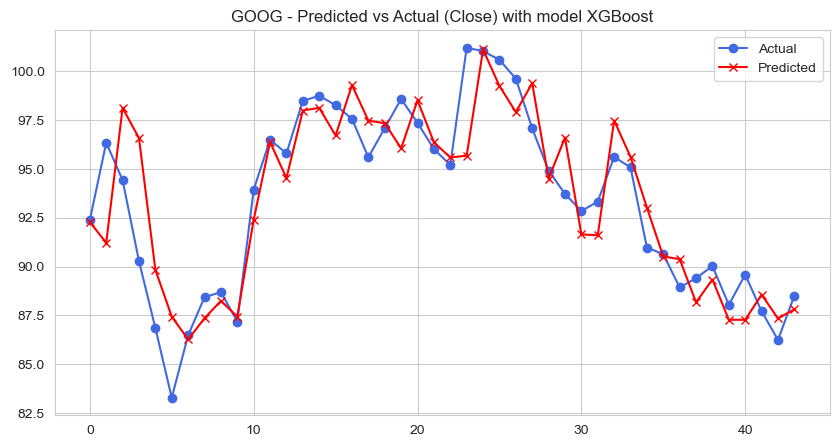

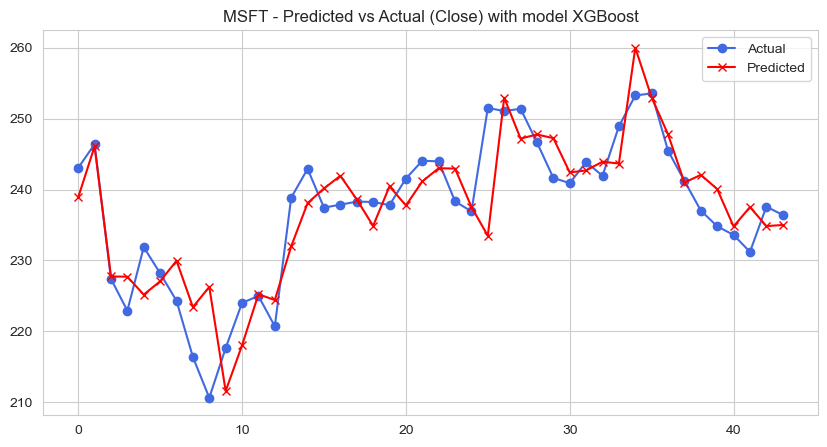

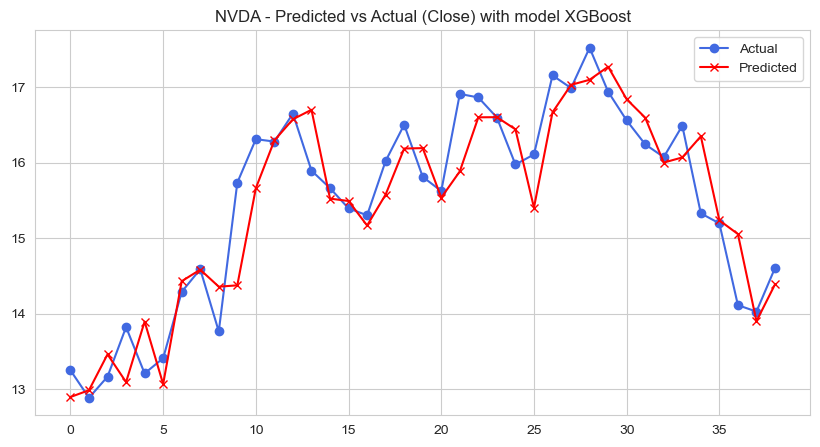

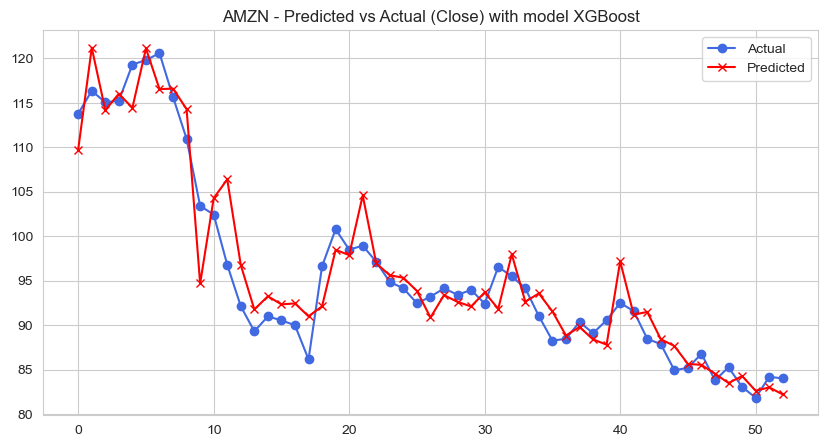

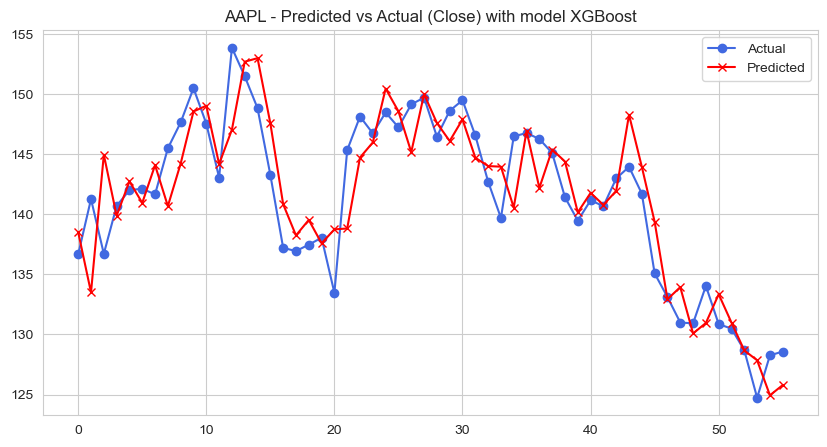

In [253]:

# plot_preds(res1, Stock_metrics[k], model='GradientBoost')
plot_preds(res1, Stock_metrics[k], model='XGBoost')
# plot_preds(res1, Stock_metrics[k], model='Random Forest')

In [ ]:

for model,  in results.items():
    plt.figure(figsize=(10, 5))
    plt.plot(result[model]['y_test'].values, label='Actual', marker='o', color = "RoyalBlue")
    plt.plot(result[model]['y_pred'], label='Predicted', marker='x' , color = "Red")
    plt.title(f'{ticker} - Predicted vs Actual ({target}) with model {model}')
plt.legend()
plt.show()     